<a href="https://colab.research.google.com/github/hwalters361/CS158_Project/blob/main/hatespeech_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [39]:
data = 'hatespeech_dataset.csv'

df = pd.read_csv(data)

In [40]:
np.random.seed(500)
Corpus = pd.read_csv(data,encoding='latin-1')
Corpus.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [41]:
Corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [42]:
# 1. Removing Blank Spaces
Corpus['tweet'].dropna(inplace=True)

In [43]:
# 2. Changing all text to lowercase
Corpus['tweet_og'] = Corpus['tweet']
Corpus['tweet'] = [entry.lower() for entry in Corpus['tweet']]

In [44]:
# 3. Tokenization-In this each entry in the corpus will be broken into set of words
Corpus['tweet']= [word_tokenize(entry) for entry in Corpus['tweet']]

In [47]:
# 4. Remove Stop words, Non-Numeric and perfoming Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

Corpus.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_og
0,0,3,0,0,3,2,"[!, !, !, rt, @, mayasolovely, :, as, a, woman...",!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,"[!, !, !, !, !, rt, @, mleew17, :, boy, dats, ...",!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,"[!, !, !, !, !, !, !, rt, @, urkindofbrand, da...",!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,"[!, !, !, !, !, !, !, !, !, rt, @, c_g_anderso...",!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,"[!, !, !, !, !, !, !, !, !, !, !, !, !, rt, @,...",!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [54]:
for index,entry in enumerate(Corpus['tweet']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'tweet_processed'] = str(Final_words)

In [55]:
Corpus.drop(['tweet'], axis=1)
output_path = 'preprocessed_data.csv'
Corpus.to_csv(output_path, index=False)

In [58]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['tweet_processed'],Corpus['class'],test_size=0.3)

In [59]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [60]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['tweet_processed'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

print(Tfidf_vect.vocabulary_)

{'rt': 3656, 'woman': 4886, 'complain': 869, 'clean': 800, 'house': 2055, 'amp': 126, 'man': 2705, 'always': 109, 'take': 4246, 'trash': 4492, 'boy': 503, 'dat': 1041, 'cold': 843, 'tyga': 4570, 'bad': 274, 'cuffin': 989, 'hoe': 2000, 'place': 3294, 'dawg': 1050, 'ever': 1398, 'fuck': 1650, 'bitch': 406, 'start': 4106, 'cry': 978, 'confuse': 887, 'shit': 3862, 'look': 2635, 'like': 2549, 'tranny': 4489, 'hear': 1944, 'might': 2811, 'true': 4521, 'tell': 4298, 'ya': 4929, 'blow': 443, 'claim': 792, 'faithful': 1454, 'somebody': 4008, 'still': 4132, 'sit': 3917, 'hate': 1927, 'another': 146, 'get': 1717, 'much': 2903, 'go': 1752, 'cause': 676, 'tire': 4439, 'big': 387, 'come': 853, 'skinny': 3926, 'girl': 1734, 'back': 268, 'thats': 4341, 'hobby': 1998, 'include': 2152, 'fighting': 1513, 'curve': 1007, 'everyone': 1403, 'lol': 2622, 'walk': 4738, 'conversation': 903, 'smh': 3967, 'murda': 2911, 'gang': 1686, 'land': 2453, 'smoke': 3971, 'loser': 2646, 'yea': 4950, 'ig': 2113, 'thing': 43

In [61]:
print(Train_X_Tfidf)

  (0, 3582)	0.261464668787434
  (0, 2705)	0.23519839924528352
  (0, 2394)	0.34392519099160973
  (0, 2373)	0.2823980303013773
  (0, 2064)	0.1513578182355102
  (0, 2012)	0.42958877102685944
  (0, 1633)	0.2863581207943312
  (0, 623)	0.23121454293876192
  (0, 266)	0.5791095888577552
  (1, 2011)	0.45492155763543235
  (1, 2000)	0.2061119301574335
  (1, 1650)	0.26053237505239574
  (1, 1061)	0.692903676594205
  (1, 545)	0.4500795764718951
  (2, 4508)	0.3946224495497825
  (2, 4093)	0.42965725710419905
  (2, 3743)	0.31415572156560473
  (2, 2037)	0.3327734763236611
  (2, 2000)	0.1486812829791784
  (2, 1927)	0.261682224317218
  (2, 1800)	0.46339759944744857
  (2, 1650)	0.1879381157161302
  (2, 103)	0.33104981324199045
  (3, 1756)	0.5039033151591711
  (3, 1447)	0.4006269898758495
  :	:
  (17343, 1720)	0.2864518354411749
  (17343, 1396)	0.2666826642804493
  (17343, 414)	0.29494423398665176
  (17343, 137)	0.4006113942383715
  (17344, 4803)	0.2966194904157301
  (17344, 4053)	0.4946250144641763
  (1734

In [62]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  83.83322125084062


In [63]:
Train_X_Tfidf.shape

(17348, 5000)

In [64]:
print(classification_report(Test_Y, predictions_NB))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       419
           1       0.83      0.99      0.91      5752
           2       0.92      0.40      0.56      1264

    accuracy                           0.84      7435
   macro avg       0.58      0.47      0.49      7435
weighted avg       0.80      0.84      0.80      7435



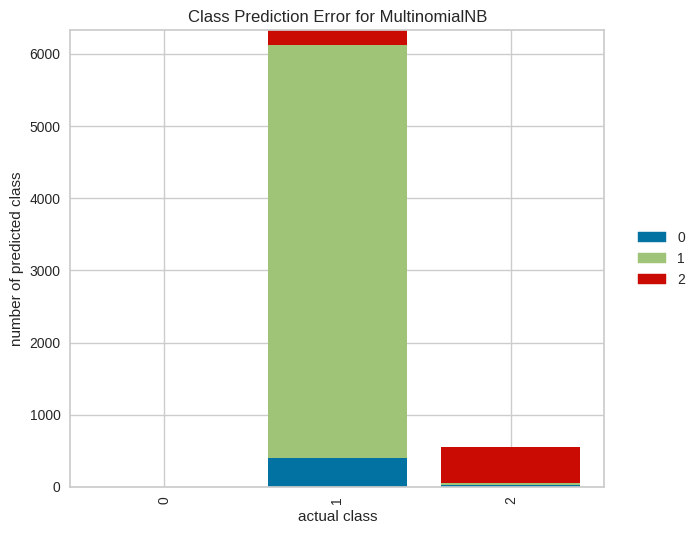

In [65]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    Naive, classes=Encoder.classes_
)

# Fit the training data to the visualizer
visualizer.fit(Train_X_Tfidf,Train_Y)

# Evaluate the model on the test data
visualizer.score(Test_X_Tfidf, Test_Y)

# Draw visualization
g = visualizer.poof()

In [73]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  90.5581708137189


In [74]:
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.51      0.16      0.24       419
           1       0.93      0.96      0.94      5752
           2       0.83      0.91      0.87      1264

    accuracy                           0.91      7435
   macro avg       0.76      0.67      0.68      7435
weighted avg       0.89      0.91      0.89      7435



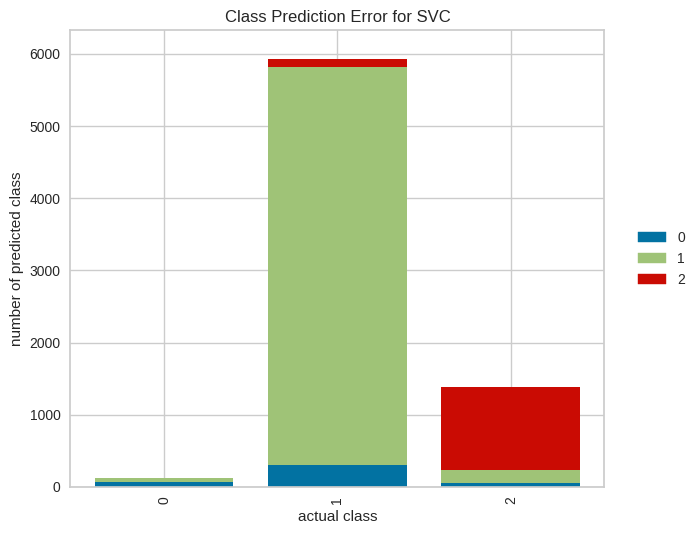

In [75]:
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVM, classes=Encoder.classes_
)

# Fit the training data to the visualizer
visualizer.fit(Train_X_Tfidf,Train_Y)

# Evaluate the model on the test data
visualizer.score(Test_X_Tfidf, Test_Y)

# Draw visualization
g = visualizer.poof()